In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy import io
import sklearn

In [2]:
fname = '../offline_data/buoy_bulkwave_met_obs_qc.mat'

In [3]:
data = io.loadmat(fname)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'time', 'hs', 'tp', 'tm', 'md', 'wndspd', 'wndgust', 'u', 'v', 'wnddir', 'id'])

In [4]:
# select one location
data['id']
ii = 20
D = {
    'time': data['time'].squeeze(),
    'hs': data['hs'][ii,:].squeeze(),
    'tm': data['tm'][ii,:].squeeze(),
    'md': data['md'][ii,:].squeeze()    
}


In [5]:
df = pd.DataFrame.from_dict(D)

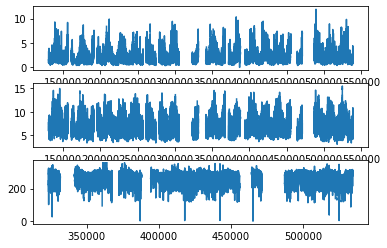

In [6]:
data['hs'].shape
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(data['hs'][1,:])
ax2.plot(data['tm'][1,:])
ax3.plot(data['md'][1,:])

Text(0.5, 0, 'Mean Period [sec]')

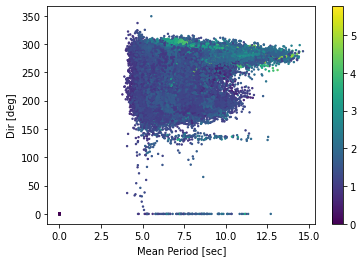

In [11]:
plt.scatter(df['tm'],df['md'],2,df['hs'])
plt.colorbar()
plt.ylabel('Dir [deg]')
plt.xlabel('Mean Period [sec]')